In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nfl_data_py as nfl

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import poisson

In [2]:
seasons = range(2016,2023)
pbp = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [4]:
pbp_pass = pbp.query('passer_id.notnull()').reset_index()
pbp_pass.head()

,index,play_id,game_id,old_game_id_x,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,...,play,passer_id,rusher_id,receiver_id,name,jersey_number,id,fantasy_player_name,fantasy_player_id,fantasy,fantasy_id,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe,nflverse_game_id,old_game_id_y,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,3,85.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,BAL,80.0,2016-09-11,872.0,1772.0,3572.0,Half1,0.0,1.0,0.0,1.0,2.0,0,14:32,BAL 20,4.0,15.0,"(14:32) (No Huddle, Shotgun) 5-J.Flacco pass s...",pass,5.0,1.0,1.0,1.0,0.0,0.0,0.0,short,right,-4.0,...,1.0,00-0026158,None,00-0026373,J.Flacco,5.0,00-0026158,J.Forsett,00-0026373,J.Forsett,00-0026373,0.0,1.0,0.644540,1.567466,9.753489,8.0,0.637670,0.530295,0.426425,57.357510,2016_01_BUF_BAL,2016091101,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",3.0,41302;40078;38540;35553;43295;38582;40053;4336...,00-0029892;00-0027714;00-0032965;00-0029893;00...,00-0031171;00-0029542;00-0029566;00-0030073;00...,11.0,11.0,-4.53,2.404,0.0,FLAT,None,None
1,5,130.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,BAL,75.0,2016-09-11,815.0,1715.0,3515.0,Half1,0.0,1.0,0.0,1.0,2.0,0,13:35,BAL 25,10.0,15.0,(13:35) (No Huddle) 5-J.Flacco pass short righ...,pass,9.0,0.0,1.0,1.0,0.0,0.0,0.0,short,right,1.0,...,1.0,00-0026158,None,00-0029892,J.Flacco,5.0,00-0026158,K.Juszczyk,00-0029892,K.Juszczyk,00-0029892,0.0,1.0,0.918295,0.902478,6.106861,5.0,0.511323,0.226924,0.499703,50.029667,2016_01_BUF_BAL,2016091101,BAL,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",5.0,40078;38540;41302;35553;38582;43295;40053;4336...,00-0029892;00-0027714;00-0032965;00-0029893;00...,00-0029542;00-0031171;00-0029566;00-0030073;00...,11.0,11.0,1.71,2.093,0.0,FLAT,None,None
2,9,216.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BUF,away,BAL,BUF,68.0,2016-09-11,704.0,1604.0,3404.0,Half1,0.0,2.0,0.0,1.0,1.0,0,11:44,BUF 32,10.0,-8.0,(11:44) (Shotgun) 5-T.Taylor pass short middle...,pass,2.0,1.0,0.0,1.0,0.0,0.0,0.0,short,middle,2.0,...,1.0,00-0028118,None,00-0027029,T.Taylor,5.0,00-0028118,L.McCoy,00-0027029,L.McCoy,00-0027029,0.0,1.0,-0.481404,0.766186,5.742206,4.0,0.664248,0.242037,0.454161,54.583950,2016_01_BUF_BAL,2016091101,BUF,SHOTGUN,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",4.0,34479;40111;41277;37249;41230;36089;37100;3567...,00-0027004;00-0030046;00-0028112;00-0031325;00...,00-0031170;00-0027560;00-0027965;00-0031296;00...,11.0,10.0,1.61,2.537,0.0,ANGLE,None,None
3,11,261.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BUF,away,BAL,BUF,72.0,2016-09-11,615.0,1515.0,3315.0,Half1,0.0,2.0,0.0,1.0,3.0,0,10:15,BUF 28,14.0,-8.0,(10:15) (Shotgun) 5-T.Taylor pass short left t...,pass,-4.0,1.0,0.0,1.0,0.0,0.0,0.0,short,left,-4.0,...,1.0,00-0028118,None,00-0030433,T.Taylor,5.0,00-0028118,M.Gillislee,00-0030433,M.Gillislee,00-0030433,0.0,1.0,-1.374502,1.258475,10.711425,10.0,0.178249,0.119315,0.940576,5.942357,2016_01_BUF_BAL,2016091101,BUF,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"1 DL, 5 LB, 5 DB",3.0,34479;40111;41277;37249;41230;36089;40112;3710...,00-0027004;00-0030046;00-0028112;00-0031325;00...,00-0031170;00-0027560;00-0027965;00-0031296;00...,10.0,10.0,-3.46,2.265,0.0,SCREEN,None,None
4,13,310.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,BAL,66.0,2016-09-11,573.0,1473.0,3273.0,Half1,0.0,3.0,0.0,1.0,1.0,0,09:33,BAL 34,10.0,13.0,(9:33) (Shotgun) 5-J.Flacco pass short right t...,

In [5]:
pbp_pass.loc[pbp_pass['pass_touchdown'].isnull(), 'pass_touchdown'] = 0
pbp_pass.loc[pbp_pass['passer'].isnull(), 'passer'] = 'none'
pbp_pass.loc[pbp_pass['passer_id'].isnull(), 'passer_id'] = 'none'


In [9]:
pbp_pass_td_y = pbp_pass \
    .groupby(['season', 'week', 'passer_id', 'passer']) \
    .agg({
        'pass_touchdown': ['sum'],
        'total_line': ['count', 'mean']
    })

pbp_pass_td_y.columns = list(map('_'.join, pbp_pass_td_y.columns.values))
pbp_pass_td_y.reset_index(inplace=True)
pbp_pass_td_y.rename(columns={
    'pass_touchdown_sum': 'pass_td_y',
    'total_line_mean': 'total_line_y',
    'total_line_count': 'n_passes'
}, inplace=True)

pbp_pass_td_y = pbp_pass_td_y[pbp_pass_td_y['n_passes'] >= 10]

pbp_pass_td_y.groupby('pass_td_y').agg({'n_passes': 'count'})

,n_passes
pass_td_y,
0.0,902
1.0,1286
2.0,1049
3.0,507
4.0,186
5.0,31
6.0,4


In [10]:
pbp_pass_td_y.describe()

,season,week,pass_td_y,n_passes,total_line_y
count,3965.000000,3965.000000,3965.000000,3965.000000,3965.000000
mean,2019.048928,9.620177,1.469861,38.802522,45.770618
std,2.008968,5.391064,1.164308,10.625023,4.409123
min,2016.000000,1.000000,0.000000,10.000000,32.000000
25%,2017.000000,5.000000,1.000000,32.000000,42.500000
50%,2019.000000,10.000000,1.000000,39.000000,45.500000
75%,2021.000000,14.000000,2.000000,46.000000,48.500000
max,2022.000000,22.000000,6.000000,84.000000,63.500000


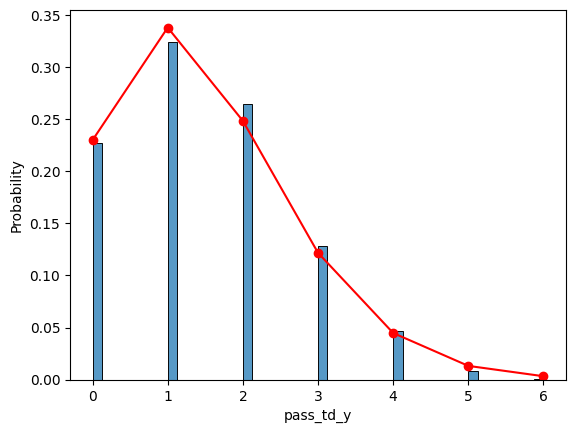

In [12]:
pass_td_y_mean = pbp_pass_td_y['pass_td_y'].mean()
plot_pos_py = pd.DataFrame({
    'x': range(0, 7),
    'y': [poisson.pmf(x, pass_td_y_mean) for x in range(0, 7)]
})
sns.histplot(pbp_pass_td_y['pass_td_y'], stat='probability')
plt.plot(plot_pos_py['x'], plot_pos_py['y'], marker='o', color='red')

In [13]:
pbp_pass_td_y_geq10 = pbp_pass_td_y.query('n_passes >= 10')

In [14]:
x = pd.DataFrame()
for season_idx in range(2017,2023):
    for week_idx in range(1,23):
        query = f"season == {season_idx} - 1 | season == {season_idx} & week == {week_idx}"
        week_calc = pbp_pass_td_y_geq10.query(query).groupby(['passer_id', 'passer']).agg({'pass_td_y': ['count', 'mean']})
        week_calc.columns = list(map('_'.join, week_calc.columns.values))
        week_calc.reset_index(inplace=True)
        week_calc.rename(columns={
            'pass_td_y_count': 'n_games',
            'pass_td_y_mean': 'pass_td_rate'
        }, inplace=True)
        week_calc['season'] = season_idx
        week_calc['week'] = week_idx
        x = pd.concat([x, week_calc])

x.head()

,passer_id,passer,n_games,pass_td_rate,season,week
0,00-0019596,T.Brady,16,2.187500,2017,1
1,00-0020531,D.Brees,17,2.235294,2017,1
2,00-0020679,S.Hill,1,0.000000,2017,1
3,00-0021206,J.McCown,6,1.000000,2017,1
4,00-0021429,C.Palmer,16,1.687500,2017,1


In [18]:
x.query('passer == "P.Mahomes"').tail()

,passer_id,passer,n_games,pass_td_rate,season,week
38,00-0033873,P.Mahomes,21,2.333333,2022,18
36,00-0033873,P.Mahomes,20,2.400000,2022,19
36,00-0033873,P.Mahomes,21,2.380952,2022,20
36,00-0033873,P.Mahomes,21,2.380952,2022,21
36,00-0033873,P.Mahomes,21,2.428571,2022,22


In [28]:
pbp_pass_td_y_geq10 = pbp_pass_td_y_geq10[pbp_pass_td_y_geq10['season'] != 2016].merge(x, how='inner', on=['passer_id', 'passer', 'season', 'week'])
pbp_pass_td_y_geq10.head()

,season,week,passer_id,passer,pass_td_y,n_passes,total_line_y,n_games_x,pass_td_rate_x,n_games_y,pass_td_rate_y
0,2017,1,00-0019596,T.Brady,0.0,45,47.5,16,2.187500,16,2.187500
1,2017,1,00-0020531,D.Brees,1.0,41,47.5,17,2.235294,17,2.235294
2,2017,1,00-0021206,J.McCown,0.0,42,42.0,6,1.000000,6,1.000000
3,2017,1,00-0021429,C.Palmer,1.0,57,48.5,16,1.687500,16,1.687500
4,2017,1,00-0022803,E.Manning,0.0,45,46.5,18,1.500000,18,1.500000


/Volumes/external/github.com/ematta/nfl/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Volumes/external/github.com/ematta/nfl/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Volumes/external/github.com/ematta/nfl/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/Volumes/external/github.com/ematta/nfl/venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient pale

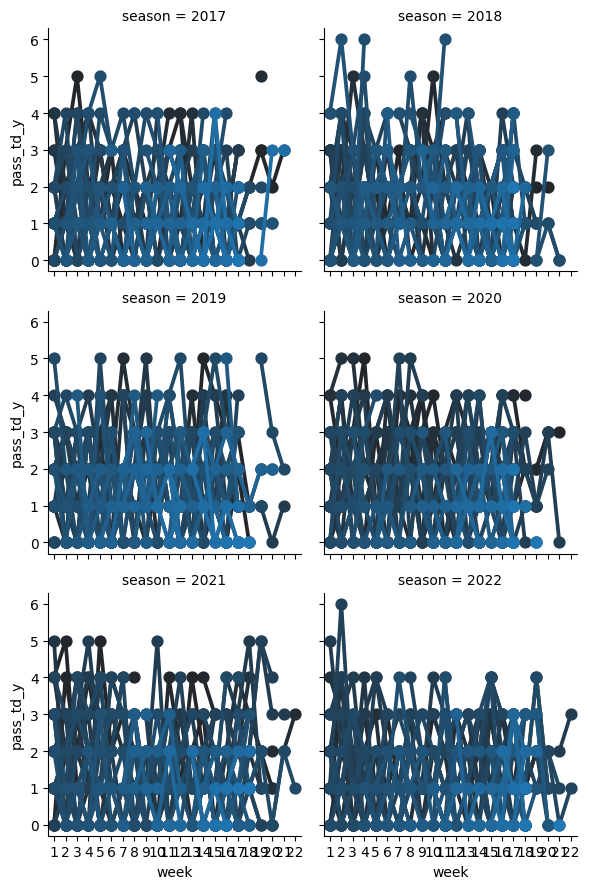

In [24]:
g = sns.FacetGrid(data=pbp_pass_td_y_geq10, col='season', col_wrap=2)
g.map_dataframe(sns.pointplot, x='week', y='pass_td_y', hue='passer')

<Axes: xlabel='pass_td_rate', ylabel='pass_td_y'>

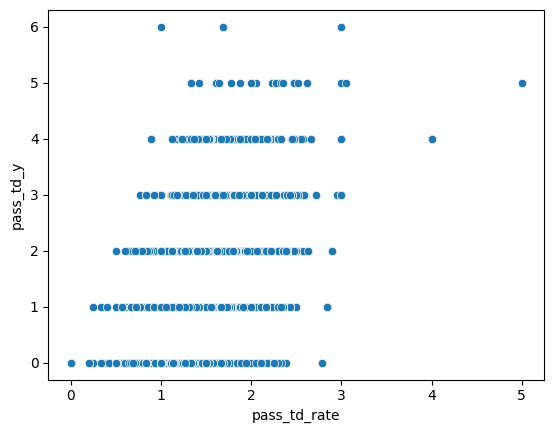

In [25]:
sns.scatterplot(data=pbp_pass_td_y_geq10, x='pass_td_rate', y='pass_td_y')

In [31]:
pass_fit = smf.glm(
    formula='pass_td_y ~ pass_td_rate_x + total_line_y',
    data=pbp_pass_td_y_geq10,
    family=sm.families.Poisson()
).fit()

pbp_pass_td_y_geq10['exp_pass_td'] = pass_fit.predict()
pass_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              pass_td_y   No. Observations:                 3411
Model:                            GLM   Df Residuals:                     3408
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4697.9
Date:                Sun, 24 Nov 2024   Deviance:                       2896.3
Time:                        15:36:14   Pearson chi2:                 2.44e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2330
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.2456      0.147     -8.491      0.000      -1.533      -0.958
pass_td_rate_x     0.5841      0.020     28.568      0.000       0.544       0.624
total_line_y       0.0149      0.003      4.672      0.000       0.009       0.021
==================================================================================
"""

In [32]:
np.exp(pass_fit.params)

Intercept         0.287761
pass_td_rate_x    1.793434
total_line_y      1.015062
dtype: float64

In [37]:
cols = [
    'season',
    'week',
    'passer',
    'total_line_y',
    'n_games_x',
    'pass_td_rate_x',
    'exp_pass_td'
]
filter = 'passer == "P.Mahomes" & season == 2022 & week == 22'

pbp_pass_td_y_geq10[cols].query(filter).sort_values('exp_pass_td', ascending=False).head(10)

,season,week,passer,total_line_y,n_games_x,pass_td_rate_x,exp_pass_td
3409,2022,22,P.Mahomes,51.0,21,2.428571,2.548227


In [39]:
pbp_pass_td_y_geq10['p_0_td'] = poisson.pmf(
    k=0,
    mu=pbp_pass_td_y_geq10['exp_pass_td']
)
pbp_pass_td_y_geq10['p_1_td'] = poisson.pmf(
    k=1,
    mu=pbp_pass_td_y_geq10['exp_pass_td']
)
pbp_pass_td_y_geq10['p_2_td'] = poisson.pmf(
    k=2,
    mu=pbp_pass_td_y_geq10['exp_pass_td']
)
pbp_pass_td_y_geq10['p_g2_td'] = 1 - poisson.cdf(
    k=2,
    mu=pbp_pass_td_y_geq10['exp_pass_td']
)
pbp_pass_td_y_geq10.query(filter).head()

,season,week,passer_id,passer,pass_td_y,n_passes,total_line_y,n_games_x,pass_td_rate_x,n_games_y,pass_td_rate_y,exp_pass_td,p_0_td,p_1_td,p_2_td,p_g2_td
3409,2022,22,00-0033873,P.Mahomes,3.0,31,51.0,21,2.428571,21,2.428571,2.548227,0.07822,0.199323,0.25396,0.468497


In [42]:
bal_td = pbp. \
    query('posteam == "BAL"'). \
    groupby(['game_id', 'week']). \
    agg({
        'touchdown': ['sum']
    })
bal_td.columns = list(map('_'.join, bal_td.columns.values))
bal_td.reset_index(inplace=True)

bal_td['week'] = bal_td['week'] - 1

bal_td.head()

,game_id,week,touchdown_sum
0,2016_01_BUF_BAL,0,1.0
1,2016_02_BAL_CLE,1,2.0
2,2016_03_BAL_JAX,2,1.0
3,2016_04_OAK_BAL,3,3.0
4,2016_05_WAS_BAL,4,2.0


In [45]:
weeks_plot = np.linspace(start=0,stop=18,num=10)
weeks_plot

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.])

Text(0.5, 1.0, 'Baltimore Ravens touchdowns per game')

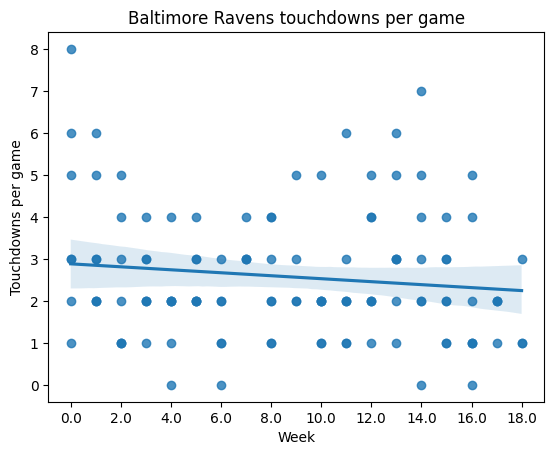

In [47]:
ax = sns.regplot(data=bal_td, x='week', y='touchdown_sum')
ax.set_xticks(ticks=weeks_plot, labels=weeks_plot)
plt.xlabel('Week')
plt.ylabel('Touchdowns per game')
plt.title('Baltimore Ravens touchdowns per game')

In [48]:
glm_bal_td = smf.glm(
    formula='touchdown_sum ~ week',
    data=bal_td,
    family=sm.families.Poisson()
).fit()

glm_bal_td.params

Intercept    1.062728
week        -0.013734
dtype: float64

In [49]:
np.exp(glm_bal_td.params)

Intercept    2.894256
week         0.986360
dtype: float64